In [1]:
import os
os.chdir('../part1_title/')


import json
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import extract_wrong_ratio, select_wrong_case_topN
from train import calc_metrics
from sklearn.metrics import accuracy_score

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", rc=custom_params)

In [2]:
def extract_results_by_method(method: str, exclude_direct_set: bool = False) -> pd.DataFrame:
    # test results path list
    if exclude_direct_set:
        test_results = glob(f'./saved_model-direct/{method}/*/exp_results_test*')
    else:
        test_results = glob(f'./saved_model-direct/{method}/*/results_test*')
    
    # load result
    total_df = pd.DataFrame()

    for result_path in test_results:
        name = os.path.basename(os.path.dirname(result_path))
        
        if exclude_direct_set:
            r = exclude_clickbait_auto(path=result_path)
        else:
            r = json.load(open(result_path,'r'))

        df = pd.DataFrame({
            'metrics' : [m.upper() for m in list(r.keys())], 
            name      : list(r.values())
        })

        df = df.round(3)
        df = df[df.metrics!='LOSS']
        df = df.set_index(keys=['metrics']).T

        total_df = pd.concat([total_df, df],axis=0)

    # order by model name
    model_list = ['FNDNet', 'HAND', 'BERT']
    order = [f + f'-{method}' for f in model_list]
    total_df = total_df.loc[order]
    total_df.columns.name = ''
    
    # set model
    total_df.index = model_list
    
    # set method
    total_df['method_name'] = method.replace('_category_select','')
    total_df = total_df[['method_name']+total_df.columns.tolist()[:-1]]
    
    # reset index
    total_df = total_df.reset_index()
    total_df = total_df.rename(columns={'index':'Model'})
    
    return total_df


def exclude_clickbait_auto(path):
    df = pd.read_csv(path)
    df = df.loc[df['filename'].apply(lambda x: False if '/Clickbait_Auto' in x else True)]

    metrics = calc_metrics(
        y_true  = df.targets.tolist(), 
        y_score = np.array(list(map(eval,df.outputs)))[:,1],
        y_pred  = df.preds.tolist()
    )

    metrics.update({
        'acc' : accuracy_score(
            y_true = df.targets.tolist(),
            y_pred = df.preds.tolist()
        )
    })
    
    return metrics

def extract_wrong_case_by_method(method):
    results_path = glob(f'./saved_model-direct/{method}/*/exp_results_test.csv')

    results_path = [r for r in results_path if method in r]
    results_path.sort()
    results_dict = {}

    for i, path in enumerate(results_path):
        modelname = os.path.basename(os.path.dirname(path))
        results_dict[modelname] = pd.read_csv(path)

    for i, (modelname, df) in enumerate(results_dict.items()):

        wrong_ratio_df = extract_wrong_ratio(df)
        wrong_ratio_df.rename(columns={'wrong / total (%)':f'{modelname.split("-")[0]} wrong / total (%)'}, inplace=True)
        
        if i == 0:
            wrong_ratio_results = wrong_ratio_df
        else:
            wrong_ratio_results = pd.merge(
                wrong_ratio_results,
                wrong_ratio_df,
                on='Category',
                how='inner'
            )
    
    wrong_ratio_results['method_name'] = modelname.split('-')[1].replace('_category_select','')
            
    return wrong_ratio_results

In [3]:
methods = [
    "random_category_select",
    "bow_title_category_select",
    "bow_content_category_select",
    "ngram_title_category_select",
    "ngram_content_category_select",
    "tfidf_title_category_select",
    "tfidf_content_category_select",
    "sentence_embedding_title_category_select",
    "sentence_embedding_content_category_select"
]

# Performance

## Include

In [4]:
results = []
for m in methods:
    results.append(extract_results_by_method(method=m))
results = pd.concat(results)

results['method_name'] = results['method_name'].apply(lambda x: 'random_title' if x == 'random' else x)
results['method_name'] = results['method_name'].apply(
    lambda x: x.replace('sentence_embedding','sentence-embedding') if 'sentence' in x else x)

results['Method'] = results['method_name'].apply(lambda x: x.split('_')[0])
results['Target'] = results['method_name'].apply(lambda x: x.split('_')[1])

method_dict = {
    'random'            : 'Random',
    'bow'               : 'BoW',
    'ngram'             : 'N-gram',
    'tfidf'             : 'TF-IDF',
    'sentence-embedding': 'Sentence\nEmbedding'
}
results['Method'] = results['Method'].map(method_dict)

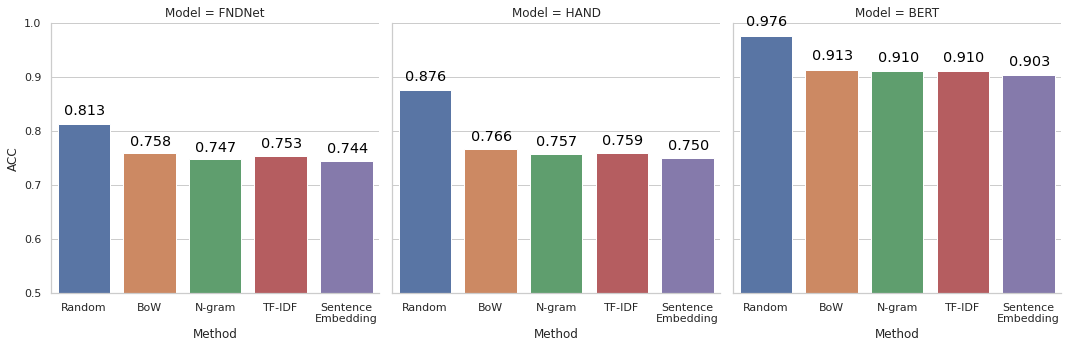

In [5]:
g = sns.catplot(
    x    = 'Method',
    y    = 'ACC',
    kind = 'bar',
    col  = 'Model',
    data = results.query("Target == 'title'")
)

plt.ylim(0.5,1)

for i in range(3):
    ax = g.facet_axis(0, i)

    for p in ax.patches:
        ax.text(p.get_x() + 0.1, 
                p.get_height() * 1.02, 
                f'{p.get_height():.3f}',   
                color='black', 
                rotation='horizontal', 
                size='large')

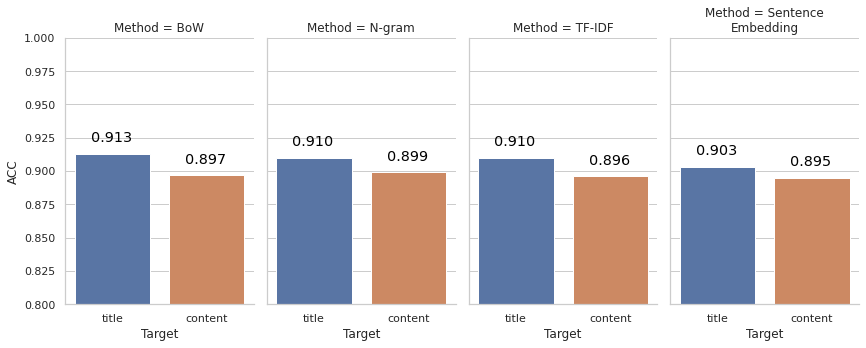

In [6]:
g = sns.catplot(
    x    = 'Target',
    y    = 'ACC',
    kind = 'bar',
    col  = 'Method',
    aspect=.6,
    data = results.query("Model == 'BERT' and Method != 'Random'")
)
plt.ylim(0.8, 1)

for i in range(4):
    ax = g.facet_axis(0, i)

    for p in ax.patches:
        ax.text(p.get_x() + 0.17, 
                p.get_height() * 1.01, 
                f'{p.get_height():.3f}',   
                color='black', 
                rotation='horizontal', 
                size='large')

## Exclude

In [7]:
results = []
for m in methods:
    results.append(extract_results_by_method(method=m, exclude_direct_set=True))
results = pd.concat(results)

results['method_name'] = results['method_name'].apply(lambda x: 'random_title' if x == 'random' else x)
results['method_name'] = results['method_name'].apply(
    lambda x: x.replace('sentence_embedding','sentence-embedding') if 'sentence' in x else x)

results['Method'] = results['method_name'].apply(lambda x: x.split('_')[0])
results['Target'] = results['method_name'].apply(lambda x: x.split('_')[1])

method_dict = {
    'random'            : 'Random',
    'bow'               : 'BoW',
    'ngram'             : 'N-gram',
    'tfidf'             : 'TF-IDF',
    'sentence-embedding': 'Sentence\nEmbedding'
}
results['Method'] = results['Method'].map(method_dict)

TN: 16556, FP: 1613, FN: 757, tp: 4256
TN: 17797, FP: 372, FN: 417, tp: 4596
TN: 14945, FP: 3224, FN: 614, tp: 4399
TN: 13903, FP: 4266, FN: 488, tp: 4525
TN: 16818, FP: 1351, FN: 339, tp: 4674
TN: 15178, FP: 2991, FN: 492, tp: 4521
TN: 16465, FP: 1704, FN: 361, tp: 4652
TN: 14090, FP: 4079, FN: 308, tp: 4705
TN: 13723, FP: 4446, FN: 447, tp: 4566
TN: 16680, FP: 1489, FN: 304, tp: 4709
TN: 13409, FP: 4760, FN: 407, tp: 4606
TN: 14062, FP: 4107, FN: 341, tp: 4672
TN: 13209, FP: 4960, FN: 373, tp: 4640
TN: 16578, FP: 1591, FN: 358, tp: 4655
TN: 13814, FP: 4355, FN: 291, tp: 4722
TN: 13638, FP: 4531, FN: 413, tp: 4600
TN: 14680, FP: 3489, FN: 348, tp: 4665
TN: 16679, FP: 1490, FN: 342, tp: 4671
TN: 13595, FP: 4574, FN: 247, tp: 4766
TN: 13077, FP: 5092, FN: 339, tp: 4674
TN: 16514, FP: 1655, FN: 355, tp: 4658
TN: 14335, FP: 3834, FN: 407, tp: 4606
TN: 13795, FP: 4374, FN: 476, tp: 4537
TN: 16815, FP: 1354, FN: 437, tp: 4576
TN: 16552, FP: 1617, FN: 361, tp: 4652
TN: 14315, FP: 3854, FN: 3

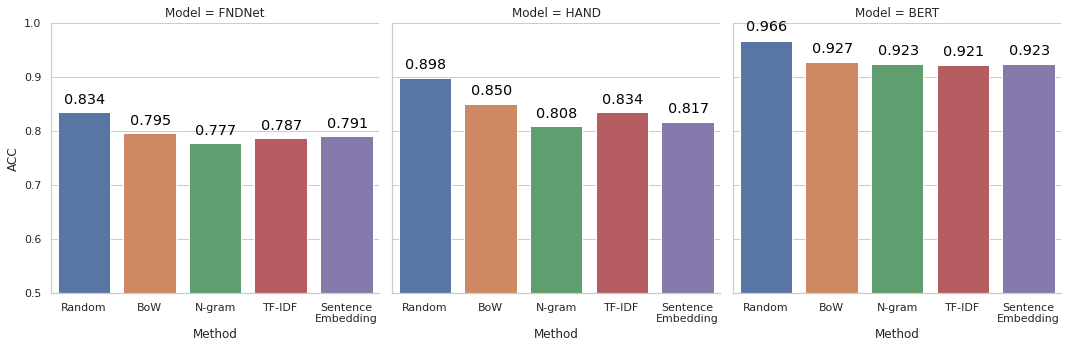

In [8]:
g = sns.catplot(
    x    = 'Method',
    y    = 'ACC',
    kind = 'bar',
    col  = 'Model',
    data = results.query("Target == 'title'")
)

plt.ylim(0.5,1)

for i in range(3):
    ax = g.facet_axis(0, i)

    for p in ax.patches:
        ax.text(p.get_x() + 0.1, 
                p.get_height() * 1.02, 
                f'{p.get_height():.3f}',   
                color='black', 
                rotation='horizontal', 
                size='large')

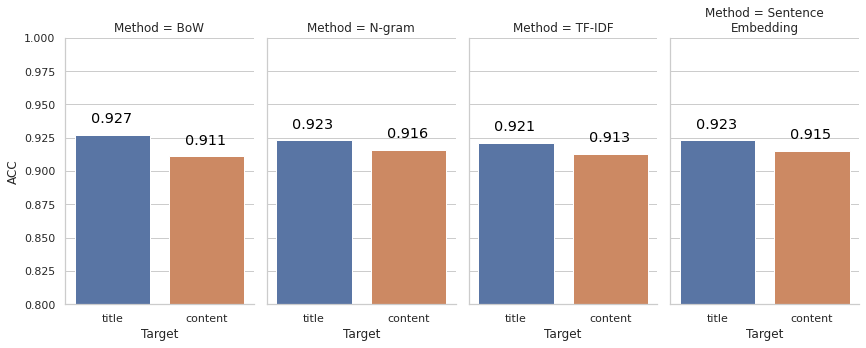

In [9]:
g = sns.catplot(
    x    = 'Target',
    y    = 'ACC',
    kind = 'bar',
    col  = 'Method',
    aspect=.6,
    data = results.query("Model == 'BERT' and Method != 'Random'")
)
plt.ylim(0.8, 1)

for i in range(4):
    ax = g.facet_axis(0, i)

    for p in ax.patches:
        ax.text(p.get_x() + 0.17, 
                p.get_height() * 1.01, 
                f'{p.get_height():.3f}',   
                color='black', 
                rotation='horizontal', 
                size='large')

# Wrong Case

In [10]:
wrong_case_results = []
for m in methods:
    wrong_case_results.append(extract_wrong_case_by_method(method=m))
wrong_case_results = pd.concat(wrong_case_results)

wrong_case_results['method_name'] = wrong_case_results['method_name'].apply(lambda x: 'random_title' if x == 'random' else x)
wrong_case_results['method_name'] = wrong_case_results['method_name'].apply(
    lambda x: x.replace('sentence_embedding','sentence-embedding') if 'sentence' in x else x)

wrong_case_results['Method'] = wrong_case_results['method_name'].apply(lambda x: x.split('_')[0])
wrong_case_results['Target'] = wrong_case_results['method_name'].apply(lambda x: x.split('_')[1])

method_dict = {
    'random'            : 'Random',
    'bow'               : 'BoW',
    'ngram'             : 'N-gram',
    'tfidf'             : 'TF-IDF',
    'sentence-embedding': 'Sentence\nEmbedding'
}
wrong_case_results['Method'] = wrong_case_results['Method'].map(method_dict)

# extract percentage
wrong_case_results['BERT'] = wrong_case_results['BERT wrong / total (%)'].apply(lambda x: x.split('(')[1][:-2])
wrong_case_results['FNDNet'] = wrong_case_results['FNDNet wrong / total (%)'].apply(lambda x: x.split('(')[1][:-2])
wrong_case_results['HAND'] = wrong_case_results['HAND wrong / total (%)'].apply(lambda x: x.split('(')[1][:-2])

# stack
wrong_case_results = wrong_case_results[['Category','Method','Target','BERT','FNDNet','HAND']]
wrong_case_results = wrong_case_results.set_index(['Category','Method','Target']).stack().reset_index()

wrong_case_results = wrong_case_results.rename(
    columns={'level_3':'Model', 0:'Wrong Case\nPercentage (%)'}
)

wrong_case_results['Wrong Case\nPercentage (%)'] = wrong_case_results['Wrong Case\nPercentage (%)'].astype(float)

cat_dict = {
    'NonClickbait_Auto' : 'Real News',
    'Clickbait_Direct'  : 'Fake News\n(Human)',
    'Clickbait_Auto'    : 'Fake News\n(Auto)'
}
wrong_case_results['Category'] = wrong_case_results['Category'].map(cat_dict)

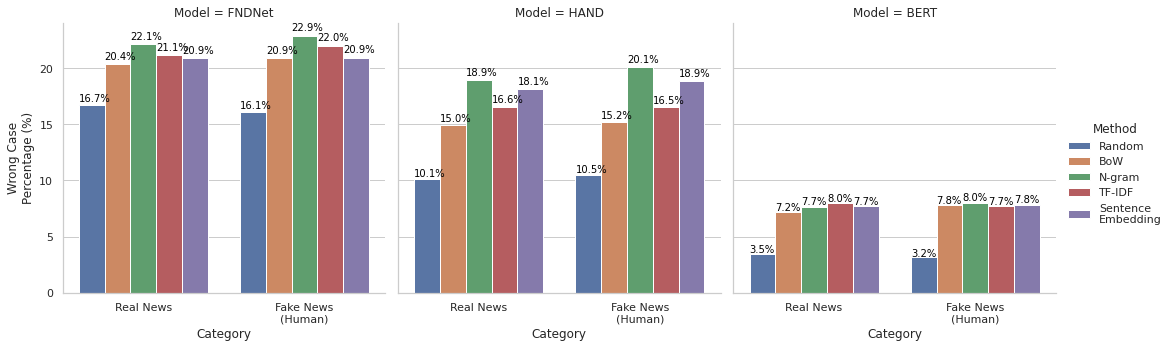

In [11]:
g = sns.catplot(
    x    = 'Category',
    y    = 'Wrong Case\nPercentage (%)',
    kind = 'bar',
    hue  = 'Method',
    col  = 'Model',    
    col_order = ['FNDNet','HAND','BERT'],
    data = wrong_case_results.query(
        "Target=='title' and Category!='Fake News\\n(Auto)'"
    )
)

for i in range(3):
    ax = g.facet_axis(0, i)

    for p in ax.patches:
        ax.text(p.get_x(), 
                p.get_height() * 1.02, 
                f'{p.get_height():.1f}%',   
                color='black', 
                rotation='horizontal', 
                size='small')

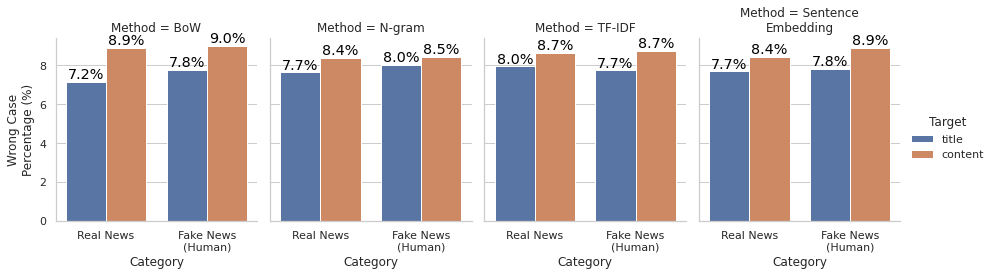

In [99]:
g = sns.catplot(
    x    = 'Category',
    y    = 'Wrong Case\nPercentage (%)',
    kind = 'bar',
    hue  = 'Target',
    col  = 'Method',
    aspect=.8,
    height=4,
    data = wrong_case_results.query(
        "Method!='Random' and Category!='Fake News\\n(Auto)' and Model=='BERT'"
    )
)

for i in range(4):
    ax = g.facet_axis(0, i)

    for p in ax.patches:
        ax.text(p.get_x() + 0.02, 
                p.get_height() * 1.02, 
                f'{p.get_height():.1f}%',   
                color='black', 
                rotation='horizontal', 
                size='large')